In [58]:
import pandas as pd

duolingo = True

if duolingo:
    df = pd.read_csv('data/duolingo/data.csv')
else:
    df = pd.read_csv('data/assistments2009.csv')
N_SKILLS = df['skill'].max()+1

In [59]:
n = df['user'].nunique()
prop_train = 0.5
n_train = int(n * prop_train)

In [60]:
n_train

606

In [61]:
import numpy as np

np.random.seed(42)
user_train = np.random.choice(df['user'].unique(), size=n_train, replace=False)
user_train[:10]

array([3169, 2446, 2974, 2667, 2573, 2632, 3464, 3064, 2456, 3534])

In [62]:
df_train = df[df['user'].isin(user_train)]
if duolingo:
    df_train = pd.read_csv('data/duolingo_train/data.csv')
else:
    df_train = pd.read_csv('data/assistments2009train.csv')
user_train = df_train['user'].unique()
df_train, df_train['user'].nunique()

(        user  skill  correct  wins  fails
 0       3112    153        1     0      0
 1       3112   1153        1     0      0
 2       3112    145        1     0      0
 3       3112   2132        1     0      0
 4       3112   2251        1     0      0
 ...      ...    ...      ...   ...    ...
 590412  2770   2250        1     1     11
 590413  2770   1002        1     1      1
 590414  2770    194        1     1     10
 590415  2770   1277        1     0      4
 590416  2770   1700        1     0      1
 
 [590417 rows x 5 columns],
 606)

In [63]:
train_users = sorted(df_train['user'].unique())
train_users

[2418,
 2419,
 2420,
 2422,
 2423,
 2424,
 2430,
 2432,
 2434,
 2437,
 2441,
 2442,
 2444,
 2445,
 2446,
 2448,
 2449,
 2450,
 2451,
 2453,
 2455,
 2456,
 2458,
 2459,
 2461,
 2462,
 2464,
 2465,
 2467,
 2468,
 2469,
 2472,
 2473,
 2474,
 2476,
 2477,
 2478,
 2479,
 2481,
 2485,
 2486,
 2488,
 2489,
 2490,
 2494,
 2495,
 2496,
 2499,
 2500,
 2501,
 2502,
 2505,
 2507,
 2510,
 2512,
 2514,
 2516,
 2518,
 2519,
 2523,
 2528,
 2534,
 2538,
 2540,
 2549,
 2553,
 2555,
 2557,
 2559,
 2562,
 2565,
 2568,
 2569,
 2571,
 2572,
 2573,
 2574,
 2576,
 2577,
 2579,
 2580,
 2581,
 2585,
 2586,
 2587,
 2589,
 2592,
 2595,
 2596,
 2599,
 2600,
 2601,
 2603,
 2604,
 2605,
 2607,
 2608,
 2610,
 2611,
 2613,
 2614,
 2617,
 2618,
 2619,
 2620,
 2623,
 2624,
 2629,
 2632,
 2633,
 2634,
 2636,
 2637,
 2640,
 2641,
 2643,
 2652,
 2655,
 2656,
 2661,
 2665,
 2666,
 2667,
 2668,
 2670,
 2675,
 2678,
 2679,
 2681,
 2683,
 2685,
 2687,
 2688,
 2689,
 2690,
 2691,
 2693,
 2697,
 2699,
 2701,
 2702,
 2705,
 2706,

In [64]:
def anonymize(df, p=0.1):
    df_anon = df.sample(frac=1-p, random_state=42).sort_index().reset_index(drop=True)
    return df_anon

In [65]:
def df_to_seq(df):
    return {
        user_id: [tuple(x) for x in user[['skill', 'correct']].to_numpy()]
        #[tuple(x) for x in user[['item_id', 'skill_id', 'correct']].to_numpy()]
        for user_id, user in df.groupby('user')
    }
seq = df_to_seq(df)
seq[list(seq.keys())[0]][:10], seq[list(seq.keys())[1]][:10]

([(145, 1),
  (2132, 1),
  (1959, 1),
  (145, 1),
  (2132, 1),
  (1941, 1),
  (145, 1),
  (1412, 1),
  (136, 1),
  (1040, 1)],
 [(151, 1),
  (1084, 1),
  (153, 0),
  (1153, 1),
  (145, 1),
  (2132, 1),
  (1959, 1),
  (145, 0),
  (2132, 0),
  (1941, 1)])

In [66]:
def combine(df, spread=1.0):
    data = []
    seq = df_to_seq(df)
    lengths = {}
    for s in seq.values():
        l = len(s)
        if l not in lengths:
            lengths[l] = 0
        lengths[l] += 1
    L = sum(lengths.values())
    for l in lengths.keys():
        lengths[l] /= L
    users = list(seq.keys())
    up = np.array([len(seq[user]) for user in users])
    up = up / up.sum()
    for user in range(len(seq)):
        l = np.random.choice(list(lengths.keys()), 1, p=list(lengths.values()))[0]
        seeds, seeds_l = [], []
        cur_l = 0
        while cur_l < l:
            seed = np.random.choice(users, 1, p=up)[0]
            ls = list(range(1, len(seq[seed])+1))
            pl = np.array([1 / l ** spread for l in ls])
            coef = np.sum(pl)
            pl /= coef
            seed_l = np.random.choice(ls, 1, p=pl)[0]
            seeds.append(seed)
            seeds_l.append(seed_l)
            cur_l += seed_l
        # should be a uniformly random partition of l of size len(seeds),
        # with max constraints varying per element
        seeds_l[-1] += (l - cur_l)
        for i in range(len(seeds)):
            seed, seed_l = seeds[i], seeds_l[i]
            start = np.random.choice(len(seq[seed]) - seed_l + 1, 1)[0]
            for j in range(seed_l):
                data.append([user, *seq[seed][start+j]])
    df_comb = pd.DataFrame(data=data, columns=['user', 'skill', 'correct'])
    return df_comb

In [67]:
%%time

df_comb = combine(df_train, spread=-10.0)
df_comb

CPU times: user 2.25 s, sys: 28.1 ms, total: 2.28 s
Wall time: 2.28 s


,user,skill,correct
0,0,297,1
1,0,1364,1
2,0,156,1
3,0,1365,1
4,0,153,0
...,...,...,...
613740,605,107,0
613741,605,1424,1
613742,605,136,1
613743,605,1424,1


In [68]:
df_train.query('user == 10')

,user,skill,correct,wins,fails


In [69]:
anonymize(df_train, p=0.99)

,user,skill,correct,wins,fails
0,3112,137,1,1,0
1,3112,1412,0,2,7
2,3112,761,0,0,0
3,3112,1959,1,0,4
4,3112,153,1,3,14
...,...,...,...,...,...
5899,2928,1336,1,0,6
5900,2911,0,0,1,2
5901,2911,1391,1,0,1
5902,2770,1652,1,0,0


In [70]:
def lcs(a, b):
    if len(a) < len(b):
        a, b = b, a
    dp = np.zeros((2, len(b)+1), dtype=int)
    for i in range(1, len(a)+1):
        for j in range(1, len(b)+1):
            if a[i-1] == b[j-1]:
                dp[i&1][j] = 1 + dp[(i&1)^1][j-1]
            else:
                dp[i&1][j] = max(dp[(i&1)^1][j], dp[i&1][j-1])
    return dp[len(a)&1,-1]

lcs([(1, 2), (2, 1), (2, 0), (3, 1), (3, 0)], [(1, 2), (3, 1), (2, 0), (2, 1), (3, 0)])

3

In [71]:
import string

ALPHABET = np.array(list(string.ascii_lowercase))

def generate_guess(n):
    return np.random.choice(ALPHABET, size=n)

D = [(''.join(generate_guess(200)), ''.join(generate_guess(200))) for _ in range(100)]

In [72]:
# lcs(seq[0], seq[1])

In [73]:
import struct

N_SKILLS = df['skill'].max()+1

def encode(s):
    # return b''.join([struct.pack(">H", skill + correct * N_SKILLS) for skill, correct in s])
    return ''.join([chr(skill + 0 * correct * N_SKILLS) for skill, correct in s])

def encode_seq(seq):
    return {user: encode(s) for user, s in seq.items()}

In [74]:
# encode(seq[0])

In [75]:
import pylcs

# pylcs.lcs(encode(seq[0]), encode(seq[1]))

In [76]:
%%time

for a, b in D:
    lcs(a, b)

CPU times: user 3.27 s, sys: 1.62 ms, total: 3.27 s
Wall time: 3.27 s


In [77]:
%%time

for a, b in D:
    pylcs.lcs(a, b)

CPU times: user 13.3 ms, sys: 6 µs, total: 13.3 ms
Wall time: 13.2 ms


In [78]:
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.metrics import roc_curve
from math import log, log2, exp
from scipy.special import logsumexp

def geom_mean(a, b, i):
    return (a ** (2 - i / 5) * b ** (i / 5)) ** 0.5

def custom_norm(norm, a, b):
    if False:
        return pylcs.lcs2(s, s2) / ([
            lambda a, b: a * b,         # product
            lambda a, b: a,             # left
            lambda a, b: b,             # right
            lambda a, b: (a * b) ** .5, # geometric mean
            lambda a, b: max(a, b),     # max
            lambda a, b: (a + b) / 2,   # mean
        ][norm])(a, b)
    else:
        return geom_mean(a, b, norm)

def score_agg(s, seq, agg, norm=1):
    return agg([
        pylcs.lcs(s, s2) / custom_norm(norm, len(s), len(s2))
        for s2 in seq.values()
    ])

def score_sum(s, seq, norm=1):
    return score_agg(s, seq, agg=sum, norm=norm)

def score_max(s, seq, norm=9.7):
    return score_agg(s, seq, agg=max, norm=norm)

def score_norm(s, seq, norm=1):
    return score_agg(s, seq, agg=np.linalg.norm, norm=norm)

def score_norm10(s, seq, norm=1):
    return score_agg(s, seq, agg=lambda l: np.linalg.norm(l, ord=10), norm=norm)

def score_LogSumExp(s, seq, norm=1):
    return score_agg(s, seq, agg=logsumexp, norm=norm)

def prob_agg(l):
    return - np.sum(np.log(np.clip(1 - np.array(l), a_min=0.1, a_max=None)))

def score_prob(s, seq, norm=1):
    return score_agg(s, seq, agg=prob_agg, norm=norm)

def median_agg(l):
    l = np.array(l)
    median = np.median(l)
    return np.sum(l[l>=median])

def score_median(s, seq, norm=1):
    return score_agg(s, seq, agg=median_agg, norm=norm)

def mean_agg(l):
    l = np.array(l)
    mean = np.mean(l)
    return np.sum(l[l>=mean])

def score_mean(s, seq, norm=1):
    return score_agg(s, seq, agg=mean_agg, norm=norm)

# Should take into account entropy of item and outcome as well
def entropy(s, p):
    return - sum(p[skill] * log2(p[skill]) for skill, correct in s)
    # return - sum(p[2*skill + correct] * log2(p[2*skill + correct]) for skill, correct in s)

def compute_skill_distrib(seq):
    cnt = [0] * N_SKILLS
    for s in seq.values():
        for skill, correct in s:
            cnt[skill] += 1
    return np.array(cnt) / sum(cnt)

def identify(seq, df_anon, score=score_max):
    seq_anon = df_to_seq(df_anon)
    seq_anon_enc = encode_seq(seq_anon)
    
    p_skill = compute_skill_distrib(seq)
    entropy_limit = (df_train['user'].nunique() / len(seq)) * log2(len(seq) / df_train['user'].nunique())
    print(entropy_limit)
    
    def foo(user, s):
        sc = score(encode(s), seq_anon_enc)
        return int(user in train_users), sc

    if True:
        y_true, y_score = map(list, zip(*Parallel(n_jobs=5)(
            delayed(foo)(user, s)
            for user, s in tqdm(
                list(filter(lambda x: entropy(x[1], p_skill) >= entropy_limit, seq.items()))
            )
        )))
    else:
        y_true, y_score = map(list, zip(*[
            foo(user, s) for user, s in tqdm(seq.items())
        ]))
    
    # plt.hist(y_score, bins=100)
    
    return roc_curve(y_true, y_score)

In [96]:
min(len(s[1]) for s in seq.items())

90

In [94]:
p_skill = compute_skill_distrib(seq)
users_tmp = list(seq.keys())
ent = [entropy(seq[user], p_skill) for user in users_tmp]
np.argmin(ent), ent[np.argmin(ent)], seq[users_tmp[np.argmin(ent)]]

(284,
 5.797087309711321,
 [(141, 1),
  (2383, 1),
  (194, 1),
  (84, 0),
  (324, 0),
  (80, 1),
  (2266, 0),
  (0, 0),
  (2240, 0),
  (2366, 1),
  (2261, 1),
  (529, 1),
  (46, 1),
  (740, 1),
  (2266, 0),
  (0, 0),
  (2240, 0),
  (46, 1),
  (2266, 0),
  (0, 0),
  (2240, 0),
  (529, 0),
  (49, 0),
  (175, 1),
  (519, 1),
  (194, 1),
  (1277, 1),
  (2132, 1),
  (981, 1),
  (84, 0),
  (324, 0),
  (1452, 1),
  (519, 1),
  (106, 1),
  (151, 0),
  (2111, 1),
  (150, 1),
  (1218, 1),
  (153, 1),
  (1307, 1),
  (156, 1),
  (691, 1),
  (145, 1),
  (1412, 1),
  (873, 1),
  (506, 1),
  (53, 1),
  (1040, 1),
  (2250, 1),
  (688, 1),
  (153, 1),
  (1997, 1),
  (1040, 1),
  (1959, 1),
  (156, 1),
  (2354, 1),
  (156, 1),
  (1306, 1),
  (153, 1),
  (787, 1),
  (153, 1),
  (688, 1),
  (1040, 1),
  (1179, 0),
  (145, 1),
  (2001, 1),
  (194, 1),
  (1277, 1),
  (2001, 1),
  (194, 1),
  (1564, 1),
  (1779, 1),
  (145, 1),
  (2132, 1),
  (1692, 1),
  (620, 1),
  (1277, 1),
  (2132, 1),
  (2251, 0),
  (1

In [22]:
# df_anon = anonymize(df_train, p=0.75)
score_roc_data = {}

In [245]:
for score in [score_sum, score_max, score_LogSumExp, score_prob, score_norm, score_norm10, score_median, score_mean]:
    print(score.__name__)
    # for norm in np.linspace(0, 10, 21):
    for norm in range(6):
        if score.__name__+str(norm) in score_roc_data:
            continue
        fpr, tpr, thresholds = identify(seq, dfs_comb[0], score=lambda a, b: score(a, b, norm=norm))
        score_roc_data[score.__name__+str(norm)] = (fpr, tpr, thresholds)

score_sum
0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:40<00:00, 87.59it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:38<00:00, 91.10it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:42<00:00, 83.48it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:43<00:00, 81.17it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:39<00:00, 88.78it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:39<00:00, 88.55it/s]


score_max
0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:40<00:00, 87.54it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:38<00:00, 91.77it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:38<00:00, 92.38it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:39<00:00, 90.26it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:37<00:00, 93.58it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:38<00:00, 92.14it/s]


score_LogSumExp
0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:39<00:00, 89.78it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:39<00:00, 89.57it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:40<00:00, 87.00it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:41<00:00, 85.04it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:39<00:00, 88.76it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:42<00:00, 82.39it/s]


score_prob
0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:40<00:00, 87.33it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:41<00:00, 84.21it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:41<00:00, 84.96it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:55<00:00, 63.49it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:55<00:00, 63.42it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:43<00:00, 81.74it/s]


score_norm
0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:44<00:00, 79.67it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:43<00:00, 81.30it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:42<00:00, 82.45it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:43<00:00, 81.35it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:43<00:00, 81.71it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:41<00:00, 84.91it/s]


score_norm10
0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:41<00:00, 85.60it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:42<00:00, 82.39it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:43<00:00, 81.56it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:44<00:00, 80.03it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:42<00:00, 83.33it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:41<00:00, 85.02it/s]


score_median
0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:43<00:00, 81.14it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:41<00:00, 84.54it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:43<00:00, 80.44it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:42<00:00, 83.58it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:41<00:00, 85.76it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:40<00:00, 86.78it/s]


score_mean
0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:42<00:00, 83.24it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:42<00:00, 82.82it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:42<00:00, 83.77it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:42<00:00, 82.60it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:40<00:00, 88.03it/s]


0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:39<00:00, 88.72it/s]


In [258]:
dfs_comb = {}
for spread in [-100, -10, -1, 0, 1, 10]:
    dfs_comb[spread] = combine(df_train, spread=spread)

In [30]:
roc_data_comb = {}

def compute_roc_comb(spread=0.0):
    if spread in roc_data_comb:
        return
    fpr, tpr, thresholds = identify(seq, dfs_comb[spread])
    roc_data_comb[spread] = (fpr, tpr, thresholds)

In [259]:
for spread in dfs_comb.keys():
    print(spread)
    compute_roc_comb(spread)

-10
0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:38<00:00, 91.55it/s]


-1
0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:48<00:00, 72.10it/s]


0
0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:55<00:00, 62.99it/s]


1
0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:45<00:00, 77.28it/s]


10
0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:44<00:00, 79.74it/s]


-100
0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:41<00:00, 85.68it/s]


In [88]:
roc_data = {}

def compute_roc(p=0.5):
    if p in roc_data:
        return
    fpr, tpr, thresholds = identify(seq, anonymize(df_train, p=p))
    roc_data[p] = (fpr, tpr, thresholds)

In [92]:
for p in [0, 0.25, 0.5, 0.75, 0.99, 0.999]:
    print(p)
    compute_roc(p)

0
0.500182234211394


100%|█████████████████████████████████████████████████████████████| 1213/1213 [10:56<00:00,  1.85it/s]


0.25
0.500182234211394


100%|█████████████████████████████████████████████████████████████| 1213/1213 [08:09<00:00,  2.48it/s]


0.5
0.500182234211394


100%|█████████████████████████████████████████████████████████████| 1213/1213 [05:10<00:00,  3.90it/s]


0.75
0.500182234211394


100%|█████████████████████████████████████████████████████████████| 1213/1213 [02:44<00:00,  7.39it/s]


0.99
0.500182234211394


100%|█████████████████████████████████████████████████████████████| 1213/1213 [00:18<00:00, 64.27it/s]


0.999
0.500182234211394


100%|████████████████████████████████████████████████████████████| 1213/1213 [00:08<00:00, 144.32it/s]


<IPython.core.display.Javascript object>


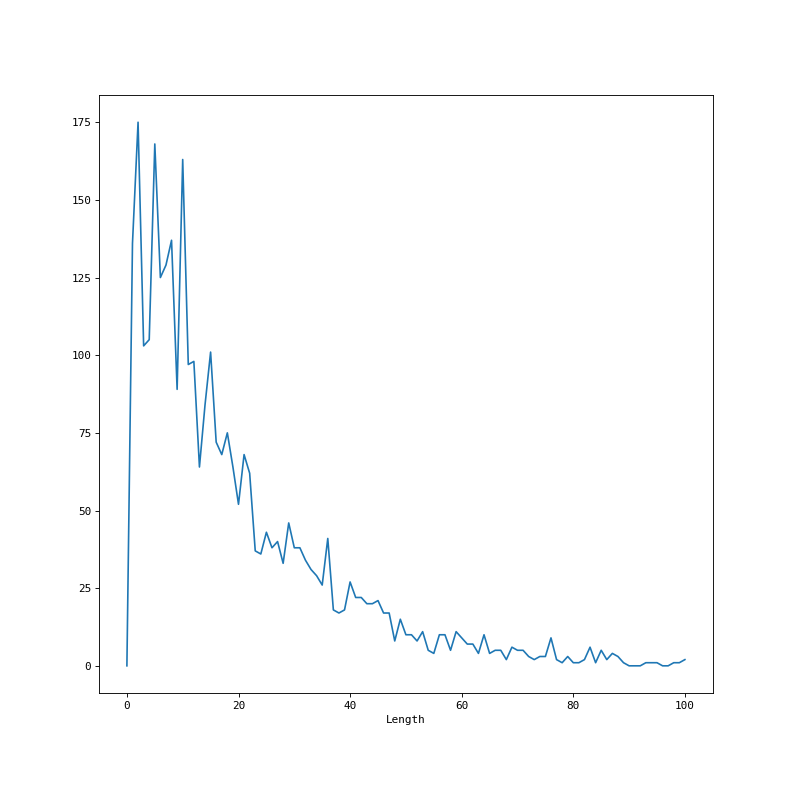

interactive(children=(FloatSlider(value=1.0, description='entl', max=2.0, min=-1.0), Output()), _dom_classes=(…

<function __main__.update(entl=1.0)>

In [208]:
%matplotlib notebook
from ipywidgets import *


def cnt_occ(l):
    d = [0] * 101
    for x in l:
        if x <= 100:
            d[x] += 1
    return d

# Create the figure and the line that we will manipulate
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

p_skill = compute_skill_distrib(seq)

line, = ax.plot(
    list(range(101)),
    cnt_occ(list(map(len, filter(lambda x: entropy(x, p_skill) < 10, seq.values()))))
)
ax.set_xlabel('Length')

def update(entl=1.0):
    line.set_ydata(
        cnt_occ(list(map(len, filter(lambda x: entropy(x, p_skill) < 10 ** entl, seq.values()))))
    )
    fig.canvas.draw_idle()

interact(update, entl=widgets.FloatSlider(min=-1, max=2, step=0.1, value=1))

In [25]:
entropy_limit = log2(len(seq) / df_train['user'].nunique())

entropy_limit, log(2) / log(10)

(1.0003465934048836, 0.30102999566398114)

NameError: name 'roc_data' is not defined

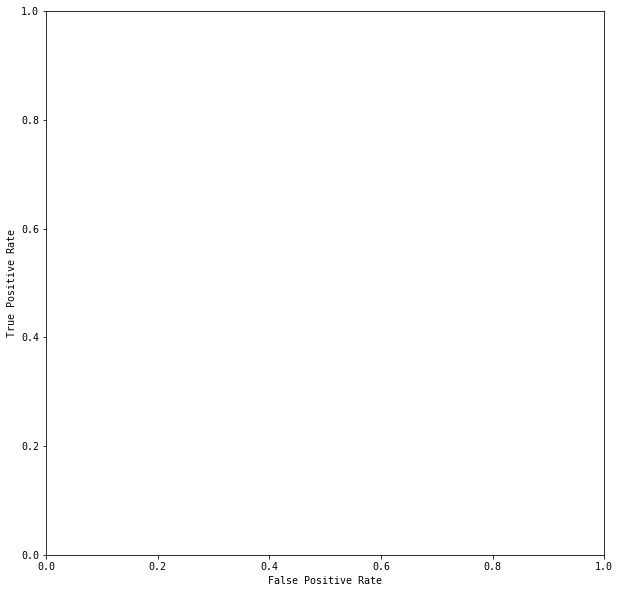

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.family'] = 'monospace'
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for p in roc_data.keys():
    (fpr, tpr, _) = roc_data[p]
    roc_auc = metrics.auc(fpr, tpr)
    print(f'{p}: {roc_auc:.3f}')
    plt.plot(fpr, tpr, label=f'drop = {p:<5} (AUC = {roc_auc:.5f})')

plt.legend()

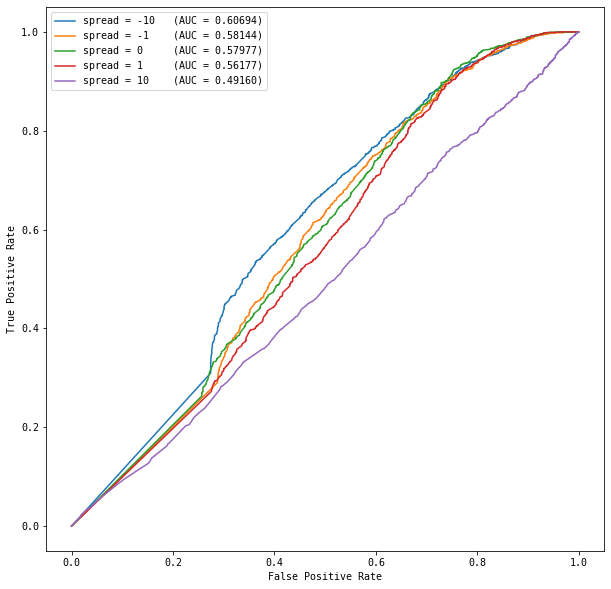

In [256]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.family'] = 'monospace'
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for spread in roc_data_comb.keys():
    (fpr, tpr, _) = roc_data_comb[spread]
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'spread = {spread:<5} (AUC = {roc_auc:.5f})')

plt.legend()

In [26]:
import re

aucs = []
X_aucs = []
for name in sorted(score_roc_data.keys()):
    (fpr, tpr, _) = score_roc_data[name]
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    X_aucs.append(float(re.findall(r"[-+]?(?:\d*\.\d+|\d+)", name)[0]))

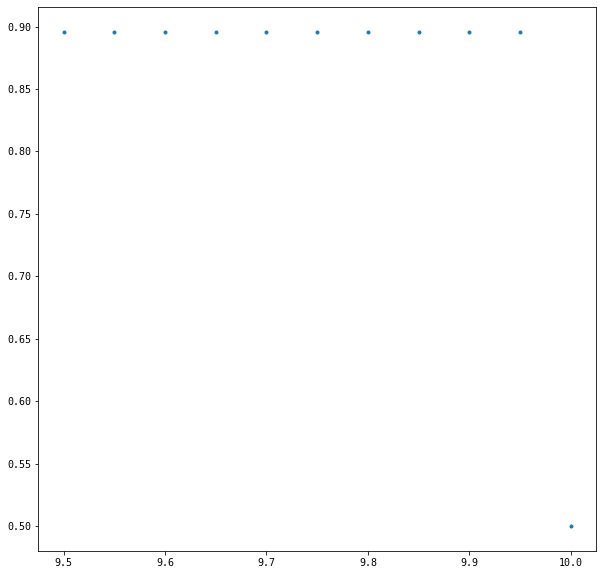

In [27]:
plt.plot(X_aucs, aucs, '.')

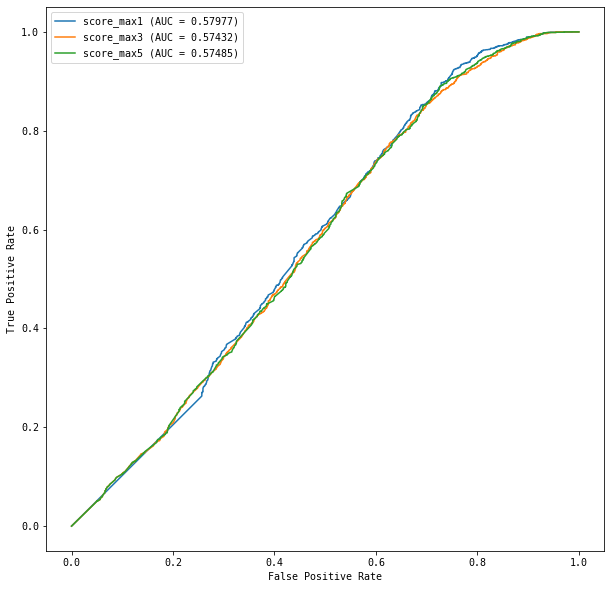

In [247]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.family'] = 'monospace'
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# for name in sorted(list(filter(lambda name: len(name) > 10 and name[7] == 'a', list(score_roc_data.keys())))):
for name in sorted(score_roc_data.keys()):
    (fpr, tpr, _) = score_roc_data[name]
    roc_auc = metrics.auc(fpr, tpr)
    if roc_auc > 0.57:
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.5f})')

plt.legend()

In [29]:
lengths = np.array([len(s) for s in seq.values() if len(s)])

((array([311., 208., 293., 266.,  89., 260., 162., 185., 140., 139.]),
  array([ 1. ,  2.8,  4.6,  6.4,  8.2, 10. , 11.8, 13.6, 15.4, 17.2, 19. ]),
  <BarContainer object of 10 artists>),
 2053)

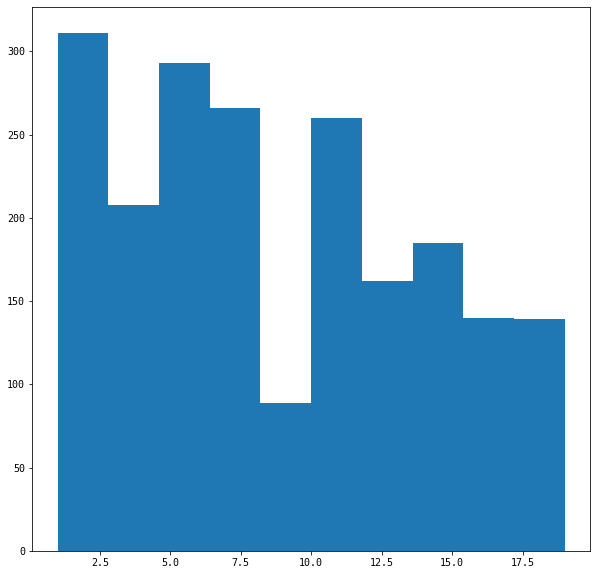

In [30]:
plt.hist(lengths[lengths < 20]), len(lengths[lengths < 20])

In [94]:
# df_train.to_csv(f'data/assistments2009train.csv', index=False)
if True:
    for drop in [0, 0.25, 0.5, 0.75, 0.99, 0.999]:
        if duolingo:
            anonymize(df_train, p=drop).to_csv(f'data/duolingo_train/gen-drop{drop}.csv', index=False)
        else:
            anonymize(df_train, p=drop).to_csv(f'data/assistments2009train-drop{drop}.csv', index=False)

In [52]:
if duolingo:
    data_path_rnn = 'data/duolingo_train/gen-bsl-500-2-32-0.001-0-16-0-laststep.csv'
    data_path_hmm = 'data/duolingo_train/gen-jjv-markov.csv'
else:
    data_path_rnn = 'data/assistments2009_train/gen-bsl-200-2-16-0.003-1-64-0.csv'
    data_path_hmm = 'data/assistments2009_train/gen-jjv-markov.csv'

In [53]:
df_rnn = pd.read_csv(data_path_rnn)
df_hmm = pd.read_csv(data_path_hmm)

In [54]:
df_rnn

,user,skill_id,skill,correct,theta
0,0,34,38,1,-0.645603
1,0,3,4,0,-0.645603
2,0,3,4,0,-0.645603
3,0,27,30,1,-0.645603
4,0,87,97,1,-0.645603
...,...,...,...,...,...
242659,2080,13,15,1,-0.148956
242660,2080,13,15,0,-0.148956
242661,2080,13,15,1,-0.148956
242662,2080,63,70,0,-0.148956


In [55]:
rnn_roc = identify(seq, df_rnn)

0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [01:02<00:00, 56.74it/s]


In [56]:
hmm_roc = identify(seq, df_hmm)

0.5000531493815908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3524/3524 [00:38<00:00, 90.92it/s]


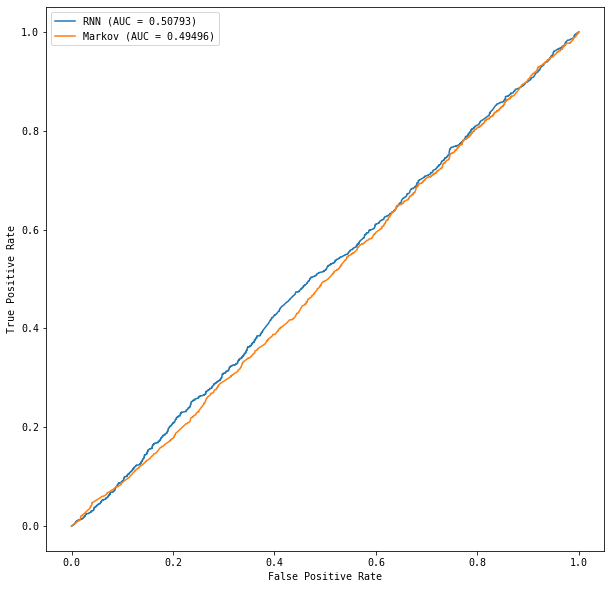

In [57]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.family'] = 'monospace'
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for p in []: # [0, 0.25, 0.5, 0.99]:
    (fpr, tpr, _) = roc_data[p]
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'drop = {p:<5} (AUC = {roc_auc:.5f})')
    
rnn_auc = metrics.auc(rnn_roc[0], rnn_roc[1]) # max3: 0.51466
plt.plot(rnn_roc[0], rnn_roc[1], label=f'RNN (AUC = {rnn_auc:.5f})')

hmm_auc = metrics.auc(hmm_roc[0], hmm_roc[1]) # max3: 0.51466
plt.plot(hmm_roc[0], hmm_roc[1], label=f'Markov (AUC = {hmm_auc:.5f})')

plt.legend()

In [37]:
identify(seq, anonymize(df_train, p=0.5))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:17<00:00, 43.87it/s]


(array([0.        , 0.00248139, 0.00248139, 0.00744417, 0.00744417,
        0.00992556, 0.00992556, 0.01240695, 0.01240695, 0.01488834,
        0.01488834, 0.01736973, 0.01736973, 0.01985112, 0.01985112,
        0.01985112, 0.01985112, 0.02233251, 0.02233251, 0.02233251,
        0.0248139 , 0.0248139 , 0.0248139 , 0.0248139 , 0.0248139 ,
        0.0248139 , 0.0248139 , 0.0248139 , 0.0248139 , 0.0248139 ,
        0.0248139 , 0.0248139 , 0.0248139 , 0.0248139 , 0.0248139 ,
        0.0248139 , 0.02729529, 0.02729529, 0.02729529, 0.02729529,
        0.02729529, 0.02729529, 0.02729529, 0.02729529, 0.02729529,
        0.02729529, 0.02729529, 0.02729529, 0.02977667, 0.02977667,
        0.02977667, 0.02977667, 0.02977667, 0.02977667, 0.02977667,
        0.02977667, 0.02977667, 0.02977667, 0.03225806, 0.03225806,
        0.03473945, 0.03473945, 0.03722084, 0.03722084, 0.03970223,
        0.03970223, 0.03970223, 0.03970223, 0.04218362, 0.04218362,
        0.04466501, 0.04466501, 0.04466501, 0.04

In [64]:
import pandas as pd
df2 = pd.read_csv('data/duolingo_train/gen-bsl-200-2-16-0.001-1-16-0.csv')

df1 = pd.read_csv('data/duolingo_train/data.csv')

df3 = pd.read_csv('data/duolingo_train/gen-jjv-markov.csv')
df1.shape, df2.shape, df3.shape

((590417, 5), (159139, 5), (617327, 9))

In [42]:
max([user for user, _ in df2.groupby('user')])

605

In [71]:
(10000 + 49) / 50

200.98

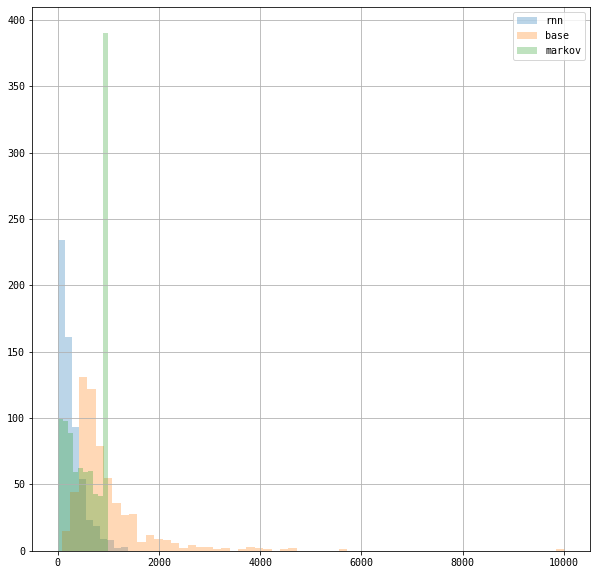

In [106]:
df2.groupby('user').size().reset_index().rename(columns={0: 'count'})['count'].hist(label='rnn', alpha=0.3)
df1.groupby('user').size().reset_index().rename(columns={0: 'count'})['count'].hist(bins=60, label='base', alpha=0.3)
df3.groupby('user').size().reset_index().rename(columns={0: 'count'})['count'].hist(bins=10, label='markov', alpha=0.3)
plt.legend()